# Assignment 1 
### Social Data and Analysis 2026 

This notebook covers solutions to multiple exercises, covering material from week 1 to 4 in the Social Data and Analysis course.

The solutions are based on analysis of a focused subset of police report data from San Francisco City and County departments.Our focus data covers police reports from year 2003 to present, and is a combination of historial and recent police report data from the San Franciso area [1, 2]. 


**In the following exercise solutions, analysis only includes data on the following nine crime catagories: assault, burglary, drug offence, vehicle theft, disorderly conduct, suspisiuos, vandalism, robbery and sex offences.**


## Assignment 1.1: Temporal Overview

We begin by providing an overview of the dataset. In this first part of the assignment, we visualize the total number of incidents per year across the nine selected focus categories. The crime rates are plotted from 2003 to 2025, excluding the current year because the data is incomplete and therefore not suitable for analysis.

Using this plot as a reference point, we then contextualize the observed trends and changes over time by relating them to real world changes. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


In [3]:
focus_data = pd.read_csv('data/focus.csv')

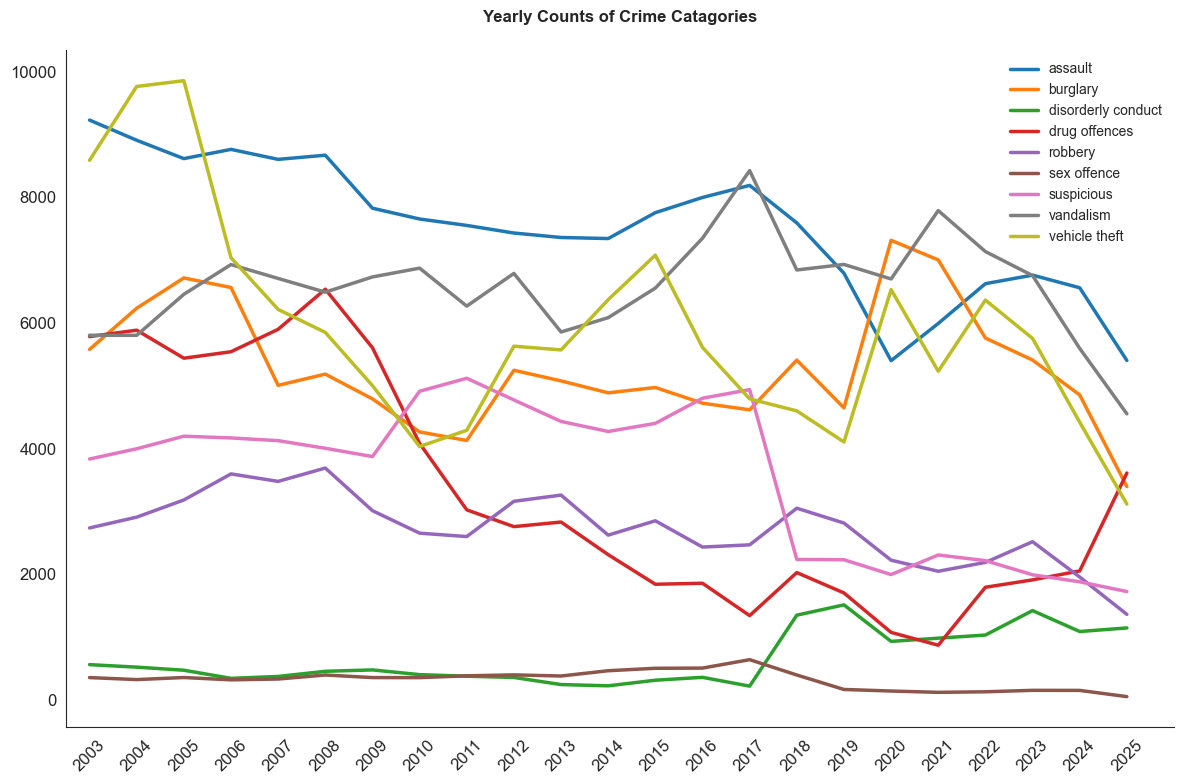

In [27]:
focus = ['assault', 'burglary', 'drug offences', 'vehicle theft', 'disorderly conduct', 'suspicious', 'vandalism', 'robbery', 'sex offence']

df_focus = focus_data[focus_data['Category'].isin(focus)]
yearly_counts = df_focus[df_focus['year'] <= 2025].groupby(['year', 'Category']).size().unstack(fill_value=0)

sns.set_style("white")
sns.set_palette("tab10")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(12, 8))
for crime in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[crime], label=crime, linewidth=2.5, markersize=8)

plt.title("Yearly Counts of Crime Catagories", fontsize=12, fontweight='bold', pad=20)

plt.xlim(2002.5, 2026.0)
plt.xticks(yearly_counts.index, rotation=45)
plt.legend(frameon=False, loc='best', fontsize=10)
sns.despine()
plt.tight_layout()

plt.show()


**Figure 1.1:** Yearly counts of crime categories (2002–2025) for nine focus crime types.

### Key take-aways in focus areas:
Figure 1.1 gives insight into how different social, political and societal changes impact the rates of recorded crimes. We explore different explanations to the most significant trends and changes. 

1) **Drop in number of assult during COVID:**
There is a noticeable drop in recorded assault offences around 2019-2020. At this time, COVID restrictions were enforced, limiting nightlife and public gatherings and reducing face-to-face interactions. This meant fewer opportunities for interpersonal violence, which is clearly reflected in the data.

2) **Surge in burglaryes and vehicle theft during covid:**
During the COVID year (2019-2021), the data shows an opposite, but just as noticeable, change — a surge in recorded vehicle thefts and burglaries. This change can also be explained by the social impacts of COVID restrictions. Empty buildings, reduced street activity, and longer periods of parked vehicles created more opportunities for property crime. Additionally, COVID was a time of increased economic stress, which likely also contributed to this rise. 

3) **Recent rise in drug offences:**
Drug offenses declines steadily for most of the timeline until around the pandemic period in 2019. This long-term decrease can be explained by a genral change in attitude towards drug use, where enforcement and arrest is reduced and replaced by diversion and treatment. By 2024, however, the data shows a surge in drug offenses, which rise above pre-pandemic levels. This reversal reflects a change in policy and enforcement focus: In response to public pressure tied to highly visible drug markets and use, San Francisco has increased enforcement of drug-related offenses [3]. In 2024, the mayor signed legislation allowing police to arrest drug users on the street and transport them to a treatment facility, putting an emphasis the city’s change in course [4]. 

4) **General decline in robberies:**
Robbery shows a general long-term downward trend. Even during periods of social disruption, as during COVID, robbery continues to decline. The trend can be explained by the shift toward cashless payments, increased surveillance, and widespread smartphone tracking, which has have reduced both the payoff and success rate of robberies. 

## Assignment 1.2: Crime Profiles by District

In [5]:
focus_data.head()

,PdId,Date,Time,DayOfWeek,IncidntNum,Incident Code,Category,Descript,Resolution,PdDistrict,Latitude,Longitude,data_loaded_at,year,month
0,152278216710,2025-10-31,17:55,Friday,250613625,16710,drug offences,"narcotics paraphernalia, possession of",Cite or Arrest Adult,MISSION,37.752270,-122.417877,2025/11/05 09:59:28 AM,2025,10
1,148998204134,2025-06-13,12:41,Friday,250329888,4134,assault,battery,Open or Active,INGLESIDE,37.718128,-122.414177,2025/06/15 09:53:25 AM,2025,6
2,149000206224,2025-05-21,00:00,Wednesday,256057940,6224,larceny theft,"theft, from unlocked vehicle, >$950",Open or Active,INGLESIDE,NaN,NaN,2025/06/15 09:53:25 AM,2025,5
3,152326906304,2025-10-23,00:00,Thursday,250618885,6304,larceny theft,"theft, from building, >$950",Open or Active,RICHMOND,37.773800,-122.498253,2025/11/05 09:59:28 AM,2025,10
4,153811216100,2026-01-08,13:44,Thursday,260013827,16100,drug offences,heroin offense,Cite or Arrest Adult,TENDERLOIN,37.785168,-122.417900,2026/01/10 09:57:31 AM,2026,1


In [6]:
# Count crimes per district per category
district_counts = df_focus.groupby(['PdDistrict', 'Category']).size().unstack(fill_value=0)
district_counts

Category,assault,burglary,disorderly conduct,drug offences,robbery,sex offence,suspicious,vandalism,vehicle theft
PdDistrict,,,,,,,,,
BAYVIEW,19543,11960,1427,5448,6863,526,9610,16668,19879
CENTRAL,17819,15269,1753,2722,6859,761,8372,19188,10596
INGLESIDE,15979,11284,961,2786,7043,634,7673,15731,21812
MISSION,26651,13719,2709,12597,10025,1331,10274,18221,18319
NORTHERN,19604,19545,2008,6225,7477,823,8650,20221,15324
OUT OF SF,205,64,76,138,69,27,249,113,547
PARK,7092,9293,661,3270,2195,373,4207,8412,9155
RICHMOND,6427,9004,584,1170,2185,338,5478,10263,9625
SOUTHERN,28519,15917,2130,13239,9721,1463,12851,22328,12819


In [7]:
# Normalize
district_profile = district_counts.div(district_counts.sum(axis=1), axis=0)


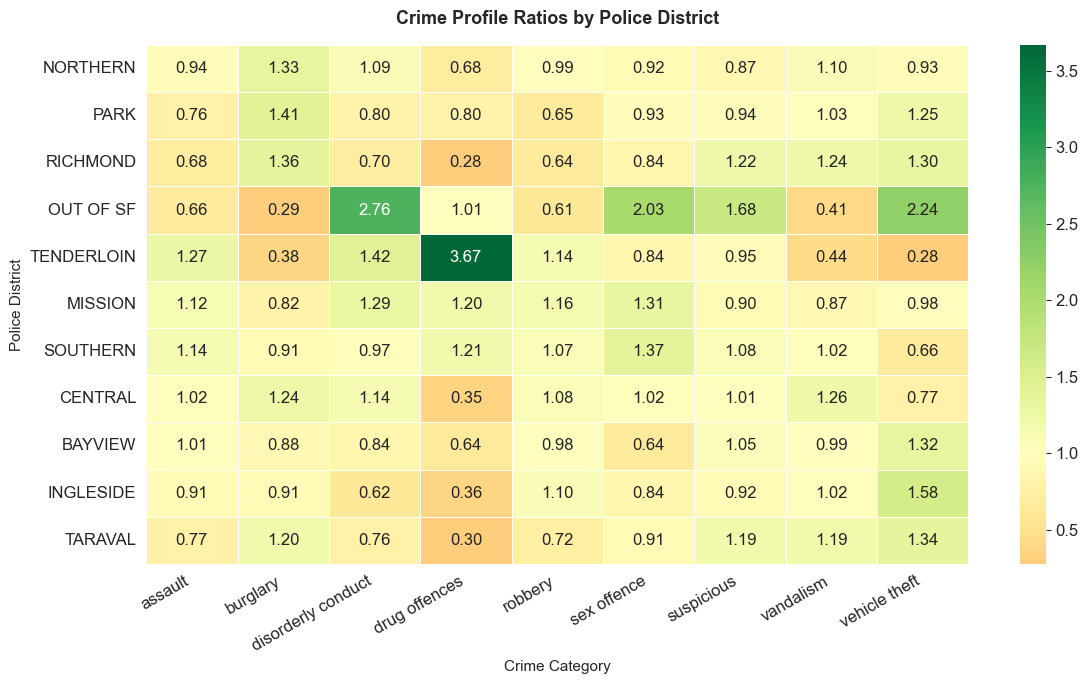

In [8]:
# Raw counts per district per crime
district_counts = df_focus.groupby(['PdDistrict', 'Category']).size().unstack(fill_value=0)

# Row-normalize to get P(crime | district)
district_profile = district_counts.div(district_counts.sum(axis=1), axis=0)

# City-wide probability for each crime P(crime | city)
city_wide = df_focus['Category'].value_counts(normalize=True)

# Divide to get the ratio — values > 1 mean over-represented
district_ratio = district_profile.div(city_wide, axis=1)

# Sort districts by dominant crime for readability
district_ratio_sorted = district_ratio.loc[district_ratio.idxmax(axis=1).sort_values().index]

plt.figure(figsize=(12, 7))
sns.heatmap(
    district_ratio_sorted,
    cmap='RdYlGn',        # green = over-represented, red = under-represented
    center=1,             # 1 is the neutral point
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    #cbar_kws={'label': 'Ratio to city-wide average (1.0 = average)'}
)
plt.title('Crime Profile Ratios by Police District', #\n(values > 1 = over-represented vs. city average)', 
          fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Crime Category', fontsize=11)
plt.ylabel('Police District', fontsize=11)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

**Figure 1.2:** Heatmap showing crime profile ratios by police district. Values greater than 1.0 (green) indicate over-representation relative to the city-wide average, while values below 1.0 (red) indicate under-representation. The Tenderloin's extreme drug offence ratio (3.28) is the most striking feature.

### Crime Profile Ratios by Police District

The heatmap shows the ratio $r(\text{crime}, \text{district}) = \frac{P(\text{crime} \mid \text{district})}{P(\text{crime})}$ for each combination of police district and crime category. A value of 1.0 means the crime occurs at exactly the city-wide average rate in that district; values above 1 indicate over-representation and values below 1 indicate under-representation.

**Tenderloin** is the most striking district in the entire heatmap. It has a drug offences ratio of **3.28** — meaning drug crime is more than three times as common there compared to the city average. At the same time, vehicle theft is heavily under-represented (0.25), which makes sense given that the Tenderloin is a dense, pedestrian-heavy neighborhood with fewer privately parked vehicles. The Tenderloin has long been the center of San Francisco's open-air drug market, and this data confirms that pattern clearly.

**Out of SF** stands out for vehicle theft (2.04) and sex offences (1.86), while having very low burglary (0.27) and assault (0.60). The high vehicle theft ratio likely reflects that incidents near highways or city boundaries — where cars are more vulnerable and less monitored — are logged under this category.

**Richmond** and **Taraval** both show elevated burglary ratios (1.42 and 1.24 respectively) and low drug offences (0.30 and 0.31). These are quieter, residential western neighborhoods with more houses and shops to burglarize, but far less street-level drug activity than central districts.

**Central** and **Northern** districts show relatively balanced profiles close to 1.0 across most categories, suggesting they reflect the city-wide average reasonably well — unsurprising given their central location covering mixed-use tourist and commercial areas.

Overall, the heatmap reveals that crime in San Francisco is far from uniformly distributed. Each district has a distinct signature shaped by its geography, land use, and socioeconomic conditions, with the Tenderloin's drug dominance being the most pronounced example.


## Assignment 1.3: Visualizing Distributions

### Part A — Jitter Plot
To investigate how incident times are recorded in the dataset, we selected assault as our focus crime and filtered incidents occurring between 13:00–14:00 over a three-month period (January–March 2015). 

In [9]:
# Filter: assault, one hour window, a few months
mask = (
    (focus_data['Category'] == 'assault') &
    (focus_data['Date'] >= '2015-01-01') &
    (focus_data['Date'] <= '2015-03-31')
)
df_jitter = focus_data[mask].copy()

In [10]:
# Extract hour and minute
df_jitter['hour'] = pd.to_datetime(df_jitter['Time'], format='%H:%M').dt.hour
df_jitter['minute'] = pd.to_datetime(df_jitter['Time'], format='%H:%M').dt.minute

# Filter to the 13:00-14:00 window
df_jitter = df_jitter[df_jitter['hour'] == 13]

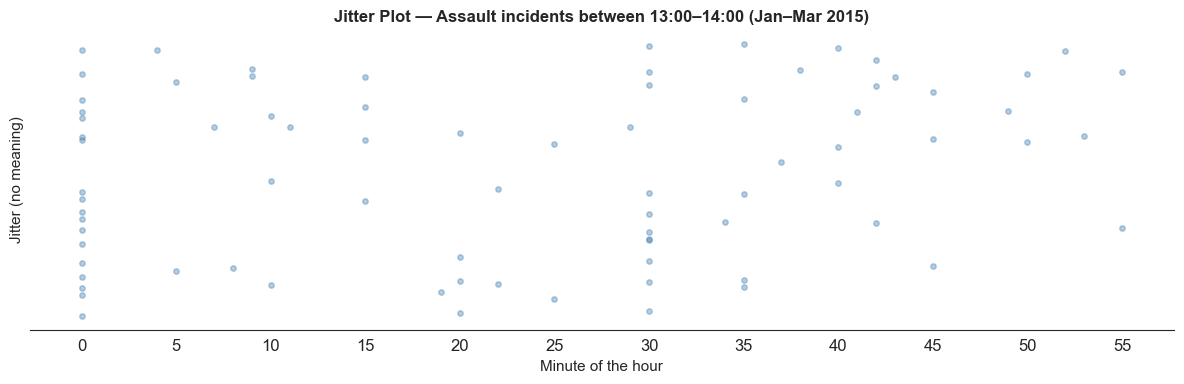

In [11]:
# Create jitter plot
plt.figure(figsize=(12, 4))
plt.scatter(
    df_jitter['minute'],
    np.random.uniform(-1, 1, size=len(df_jitter)),  # vertical jitter
    alpha=0.4,
    s=15,
    color='steelblue'
)
plt.xlabel('Minute of the hour', fontsize=11)
plt.ylabel('Jitter (no meaning)', fontsize=11)
plt.title('Jitter Plot — Assault incidents between 13:00–14:00 (Jan–Mar 2015)', fontsize=12, fontweight='bold')
plt.xticks(range(0, 60, 5))
plt.yticks([])
sns.despine(left=True)
plt.tight_layout()
plt.show()

**Figure 1.3:** Jitter plot showing recorded times for assault incidents between 13:00–14:00 (January–March 2015). The pronounced spike at minute 0 and smaller cluster at minute 30 indicate systematic rounding of incident times to the nearest hour or half-hour.

Each dot represents one recorded incident, with the x-axis showing the minute within the hour and vertical jitter added purely to separate overlapping points.
The most immediately striking pattern is the large cluster of incidents recorded at minute 0 (i.e. exactly on the hour). This spike is far larger than any other minute, suggesting that officers frequently round the time of an incident to the nearest full hour when filing their report. A smaller but still noticeable cluster appears at minute 30, consistent with rounding to the half hour as well.
Outside of these two peaks, incidents are scattered relatively thinly and somewhat randomly across the other minutes, with no other strong clustering visible.
This tells us something important about the precision of the data: recorded times should not be treated as exact measurements. A significant fraction of incidents have their time rounded to the nearest hour or half hour, meaning any fine-grained time analysis (e.g. "crimes peak at 13:07") would be misleading. For broad hourly analysis this is not a major problem, but it is a limitation worth keeping in mind.

### Part B — Probability plot:

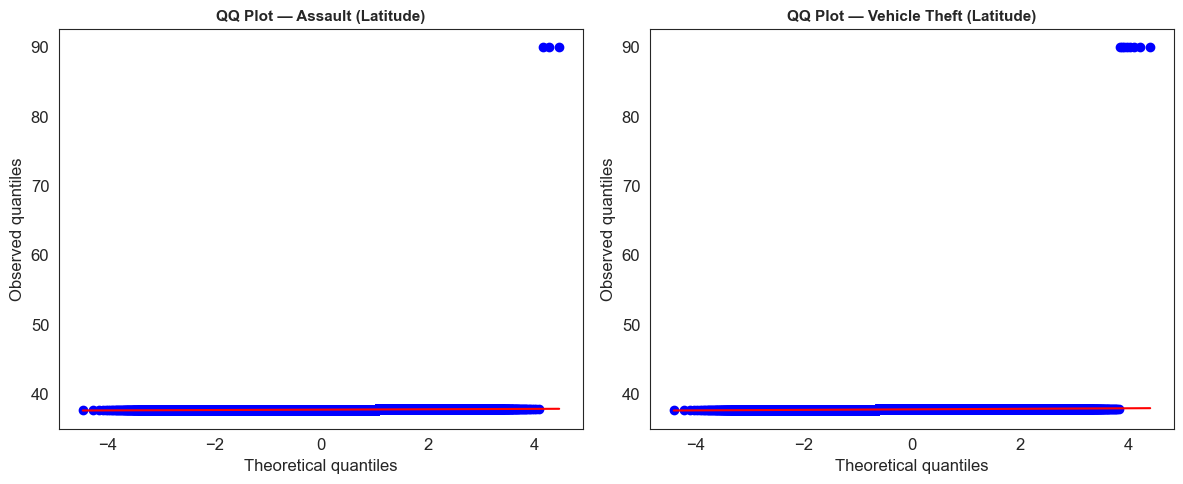

In [12]:
# Pick two crimes to compare
crimes_qq = ['assault', 'vehicle theft']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, crime in zip(axes, crimes_qq):
    subset = focus_data[focus_data['Category'] == crime]['Latitude'].dropna()
    stats.probplot(subset, dist='norm', plot=ax)
    ax.set_title(f'QQ Plot — {crime.title()} (Latitude)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Theoretical quantiles')
    ax.set_ylabel('Observed quantiles')

plt.tight_layout()
plt.show()

**Figure 1.4:** Q-Q plots comparing the distribution of incident latitude for assault and vehicle theft crimes against a theoretical normal distribution. Significant deviations from the diagonal line indicate non-normal spatial distributions, reflecting the clustered geography of these crimes in San Francisco.

In [13]:
focus_data.columns.tolist()


['PdId',
 'Date',
 'Time',
 'DayOfWeek',
 'IncidntNum',
 'Incident Code',
 'Category',
 'Descript',
 'Resolution',
 'PdDistrict',
 'Latitude',
 'Longitude',
 'data_loaded_at',
 'year',
 'month']

We need to get the X,Y from the original data!

In [14]:
focus_data["PdDistrict"].value_counts().head(15)

PdDistrict
SOUTHERN      255323
NORTHERN      222611
CENTRAL       204458
MISSION       187376
BAYVIEW       134511
INGLESIDE     124692
TENDERLOIN    115130
TARAVAL       115123
RICHMOND       95160
PARK           82133
OUT OF SF       4845
Name: count, dtype: int64

## Assingmet 1.4: Spatial Power Law
In this exercise we look at the spatial disribution of crime. The aim is to uncover wheter crime in evenly distributed trough out the city, or concentrated only in a few hotspots. To do so, we define a grid overlay, count the number of crimes in each grid and finaly analyse the frequency distribution. 

First we look up the most commen crimes from our focus groups. 

In [15]:
# Step 0: Find the most common focus crimes by incident count
crime_counts = df_focus['Category'].value_counts()

top_crime = crime_counts.head(1).index.tolist()
print(f"Most commen type of crime:")
for i, crime in enumerate(top_crime, 1):
    print(f"  {i}. {crime} ({crime_counts[crime]} incidents)")

# We'll analyze all three crimes
crimes_to_analyze = top_crime

Most commen type of crime:
  1. assault (173514 incidents)


We will focus on Assualt wich is the most commen type crime, among our focus catagories.

Next we define a $100m \times 100 m$ grid to cover the entire area of San Francisco.

In [ ]:
def getXYpos_meters(latitudes, longitudes, ref_lat, ref_lon):
    """Converts lat/lon to X,Y distances in meters from a reference point (center of map).
    
    Args:
        latitudes: array of latitudes
        longitudes: array of longitudes
        ref_lat: reference latitude (default SF downtown)
        ref_lon: reference longitude (default SF downtown)
    
    Returns:
        x_meters, y_meters: arrays of distances in meters
    """
    deltaLatitude = latitudes - ref_lat
    deltaLongitude = longitudes - ref_lon
    latitudeCircumference = 40075160 * np.cos(np.radians(ref_lat))
    resultX = deltaLongitude * latitudeCircumference / 360
    resultY = deltaLatitude * 40008000 / 360
    return resultX, resultY

# Calculate the center (middle) of the map as the null point
center_lat = df_focus['Latitude'].mean()
center_lon = df_focus['Longitude'].mean()

# Convert all coordinates to meters using map center as reference
x_meters, y_meters = getXYpos_meters(df_focus['Latitude'].values, df_focus['Longitude'].values, 
                                    ref_lat=center_lat, ref_lon=center_lon)



Map center (null point): 37.767484°N, -122.423555°W


In [28]:
# Source - https://stackoverflow.com/a/39277772
# Posted by Martin Valgur, modified by community. See post 'Timeline' for change history
# Retrieved 2026-02-25, License - CC BY-SA 4.0

# Create 100m grid bins
grid_step = 100  # meters
to_bin = lambda x: np.floor(x / grid_step) * grid_step

# Create an explicit copy to avoid SettingWithCopyWarning
df_focus = df_focus.copy()
df_focus["xBin"] = to_bin(x_meters)
df_focus["yBin"] = to_bin(y_meters)
groups = df_focus.groupby(["xBin", "yBin"])

print(f"Grid cells created: {len(groups)}")
print(f"Total incidents in all grids: {len(df_focus)}")
print(f"Grid bin size: {grid_step}m × {grid_step}m")

Grid cells created: 8838
Total incidents in all grids: 827793
Grid bin size: 100m × 100m


Next we count the number of crimes in each grid. We then calcuate the frequency distribution, counting how many cells have $k = 1, \dots , max$ crimes, where max is the highest number of assualt in a single cell. 

Lastly, the frequency distribution is plotted on both linear and loglog axes. 

In [18]:
for crime in crimes_to_analyze:
    # Filter data for THIS specific crime type ONLY
    crime_df = df_focus[df_focus['Category'] == crime].copy()
    
    # Verify we have the right crime
    assert crime_df['Category'].unique().tolist() == [crime], f"Error: Got multiple crime types!"
    
    # Count this specific crime in each grid cell
    crime_counts = crime_df.groupby(["xBin", "yBin"]).size()
    
    print(f"\n Focus crime: {crime.title()}")
    print(f"{'='*50}")
    print(f"  Total {crime} incidents: {len(crime_df)}")
    print(f"  Grid cells with {crime}: {len(crime_counts)}")
    print(f"  Mean {crime} per cell: {crime_counts.mean():.2f}")
    print(f"  Max {crime} in single cell: {crime_counts.max()}")
    print(f"  Median {crime} per cell: {crime_counts.median():.0f}")
    
    # Compute the frequency distribution N(k) for this crime only
    incident_freq = crime_counts.value_counts().sort_index()



 Focus crime: Assault
  Total assault incidents: 173514
  Grid cells with assault: 7813
  Mean assault per cell: 22.20
  Max assault in single cell: 3032
  Median assault per cell: 6


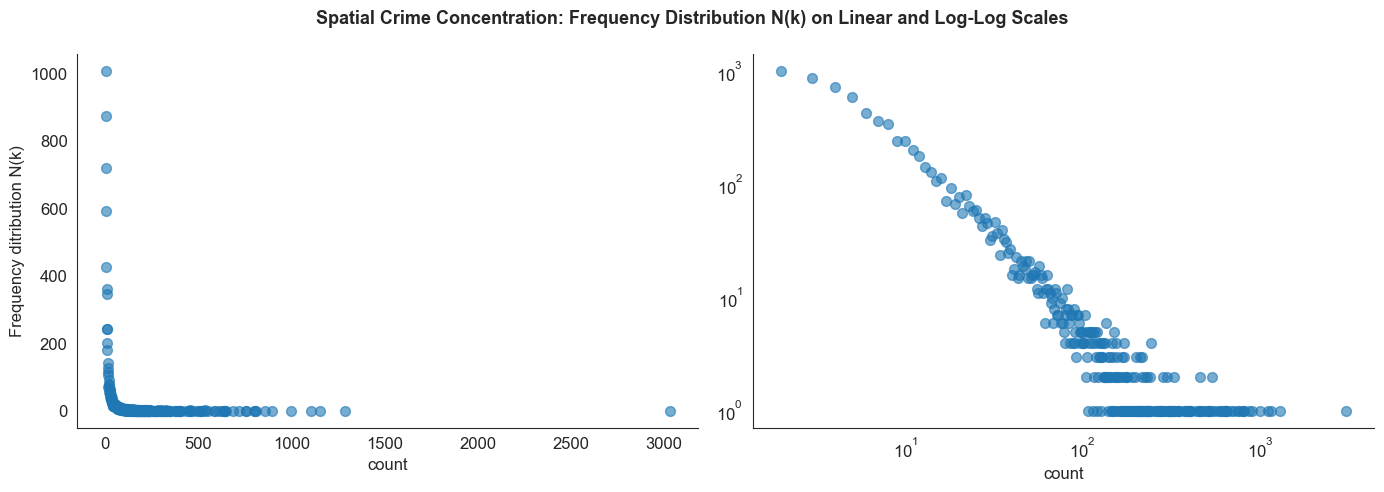

In [ ]:
# Plot N(k) vs k+1 for all crimes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.despine()
sns.set_style("white")
sns.set_palette("tab10")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

for crime in crimes_to_analyze:
    # Filter data for this crime type
    crime_df = df_focus[df_focus['Category'] == crime]
    crime_counts = crime_df.groupby(["xBin", "yBin"]).size()
    
    # Get the frequency distribution N(k)
    incident_freq = crime_counts.value_counts().sort_index()
    
    # k+1 (shift by 1 to avoid log(0))
    k_plus_1 = incident_freq.index + 1
    N_k = incident_freq.values
    
    # Linear plot
    axes[0].scatter(k_plus_1, N_k, label=crime.title(), alpha=0.6, s=50)
    
    # Log-log plot
    axes[1].scatter(k_plus_1, N_k, label=crime.title(), alpha=0.6, s=50)

# Linear axes plot
axes[0].set_xlabel('count', fontsize=12)
axes[0].set_ylabel('Frequency ditribution N(k)', fontsize=12)
# Log-log axes plot
axes[1].set_xlabel('count', fontsize=12)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
sns.despine(ax=axes[0])

fig.suptitle('Spatial Crime Concentration: Frequency Distribution N(k) on Linear and Log-Log Scales', fontsize=13, fontweight='bold', y=0.98)


plt.tight_layout()
plt.show()


**Figure 1.4:** The figure shows the frequency distribution $N(k)$ plotted against number of crimes $k$ starting from $k=1$. The plot reveals a power law distribution. 

### Power law distribution 

Figure 1.4 provides strong visual evidence for a **power law distribution**. 
- On **linear scales** the distribution is crushed long the axes. Most vlaues lie in the low end, meanwhile there is a heavy tail, with only very few values over larger counts. 
- On **log-log scales** the power law distribution becomes clear. Values fall approximately along a striaght line over a range of counts. 


The power law distribution implies that there are many low-frequnece areas (grids) and only a few areas with heavy assault crime frequency. 




### What does the spatial concentration imply for neighborhood-level assault statistics?

Assault incidents follow a power-law distribution and are spatially concentrated in a small number of grid cells. This has important implications for how we interpret neighborhood-level assault statistics.

Because crime is heavily concentrated in a few hotspots, the average number of crimes per grid cell becomes misleading. The mean is not representative of the “typical” neighborhood. instead, a small number of grids with very high crime counts drive the average upward, while most areas experience far fewer incidents.

This skewness is clearly illustrated by the difference between the mean (22) and the median (6). The gap between these two measures tells us, that most grid cells have assault counts well below the average. The mean is inflated by a small number of high-crime hotspots. In fact, the grid with most crimes has 3032 recordings.

When we average the number of crimes on a neiborhood level, it has a misleading effect in practice: The city appears moderately dangourous on average but in reality it consists of mostly safe neiborhoods with a only few areas with very high concentrations of crime.

## Assignment 1.5: Regression and Correlation

To match the Week 4 workflow, we use all 9 personal focus crimes from this report. For each crime type, we compute a 168-dimensional vector (one count per hour of the week, Monday 00:00 to Sunday 23:00), then compare all pairwise combinations with closed-form linear regression and $R^2$.


/var/folders/zz/2c1rbk_j1vj12wnhcn4mywn40000gn/T/ipykernel_33711/2504798093.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_15.groupby(["Category", "DayOfWeek", "hour"]).size()


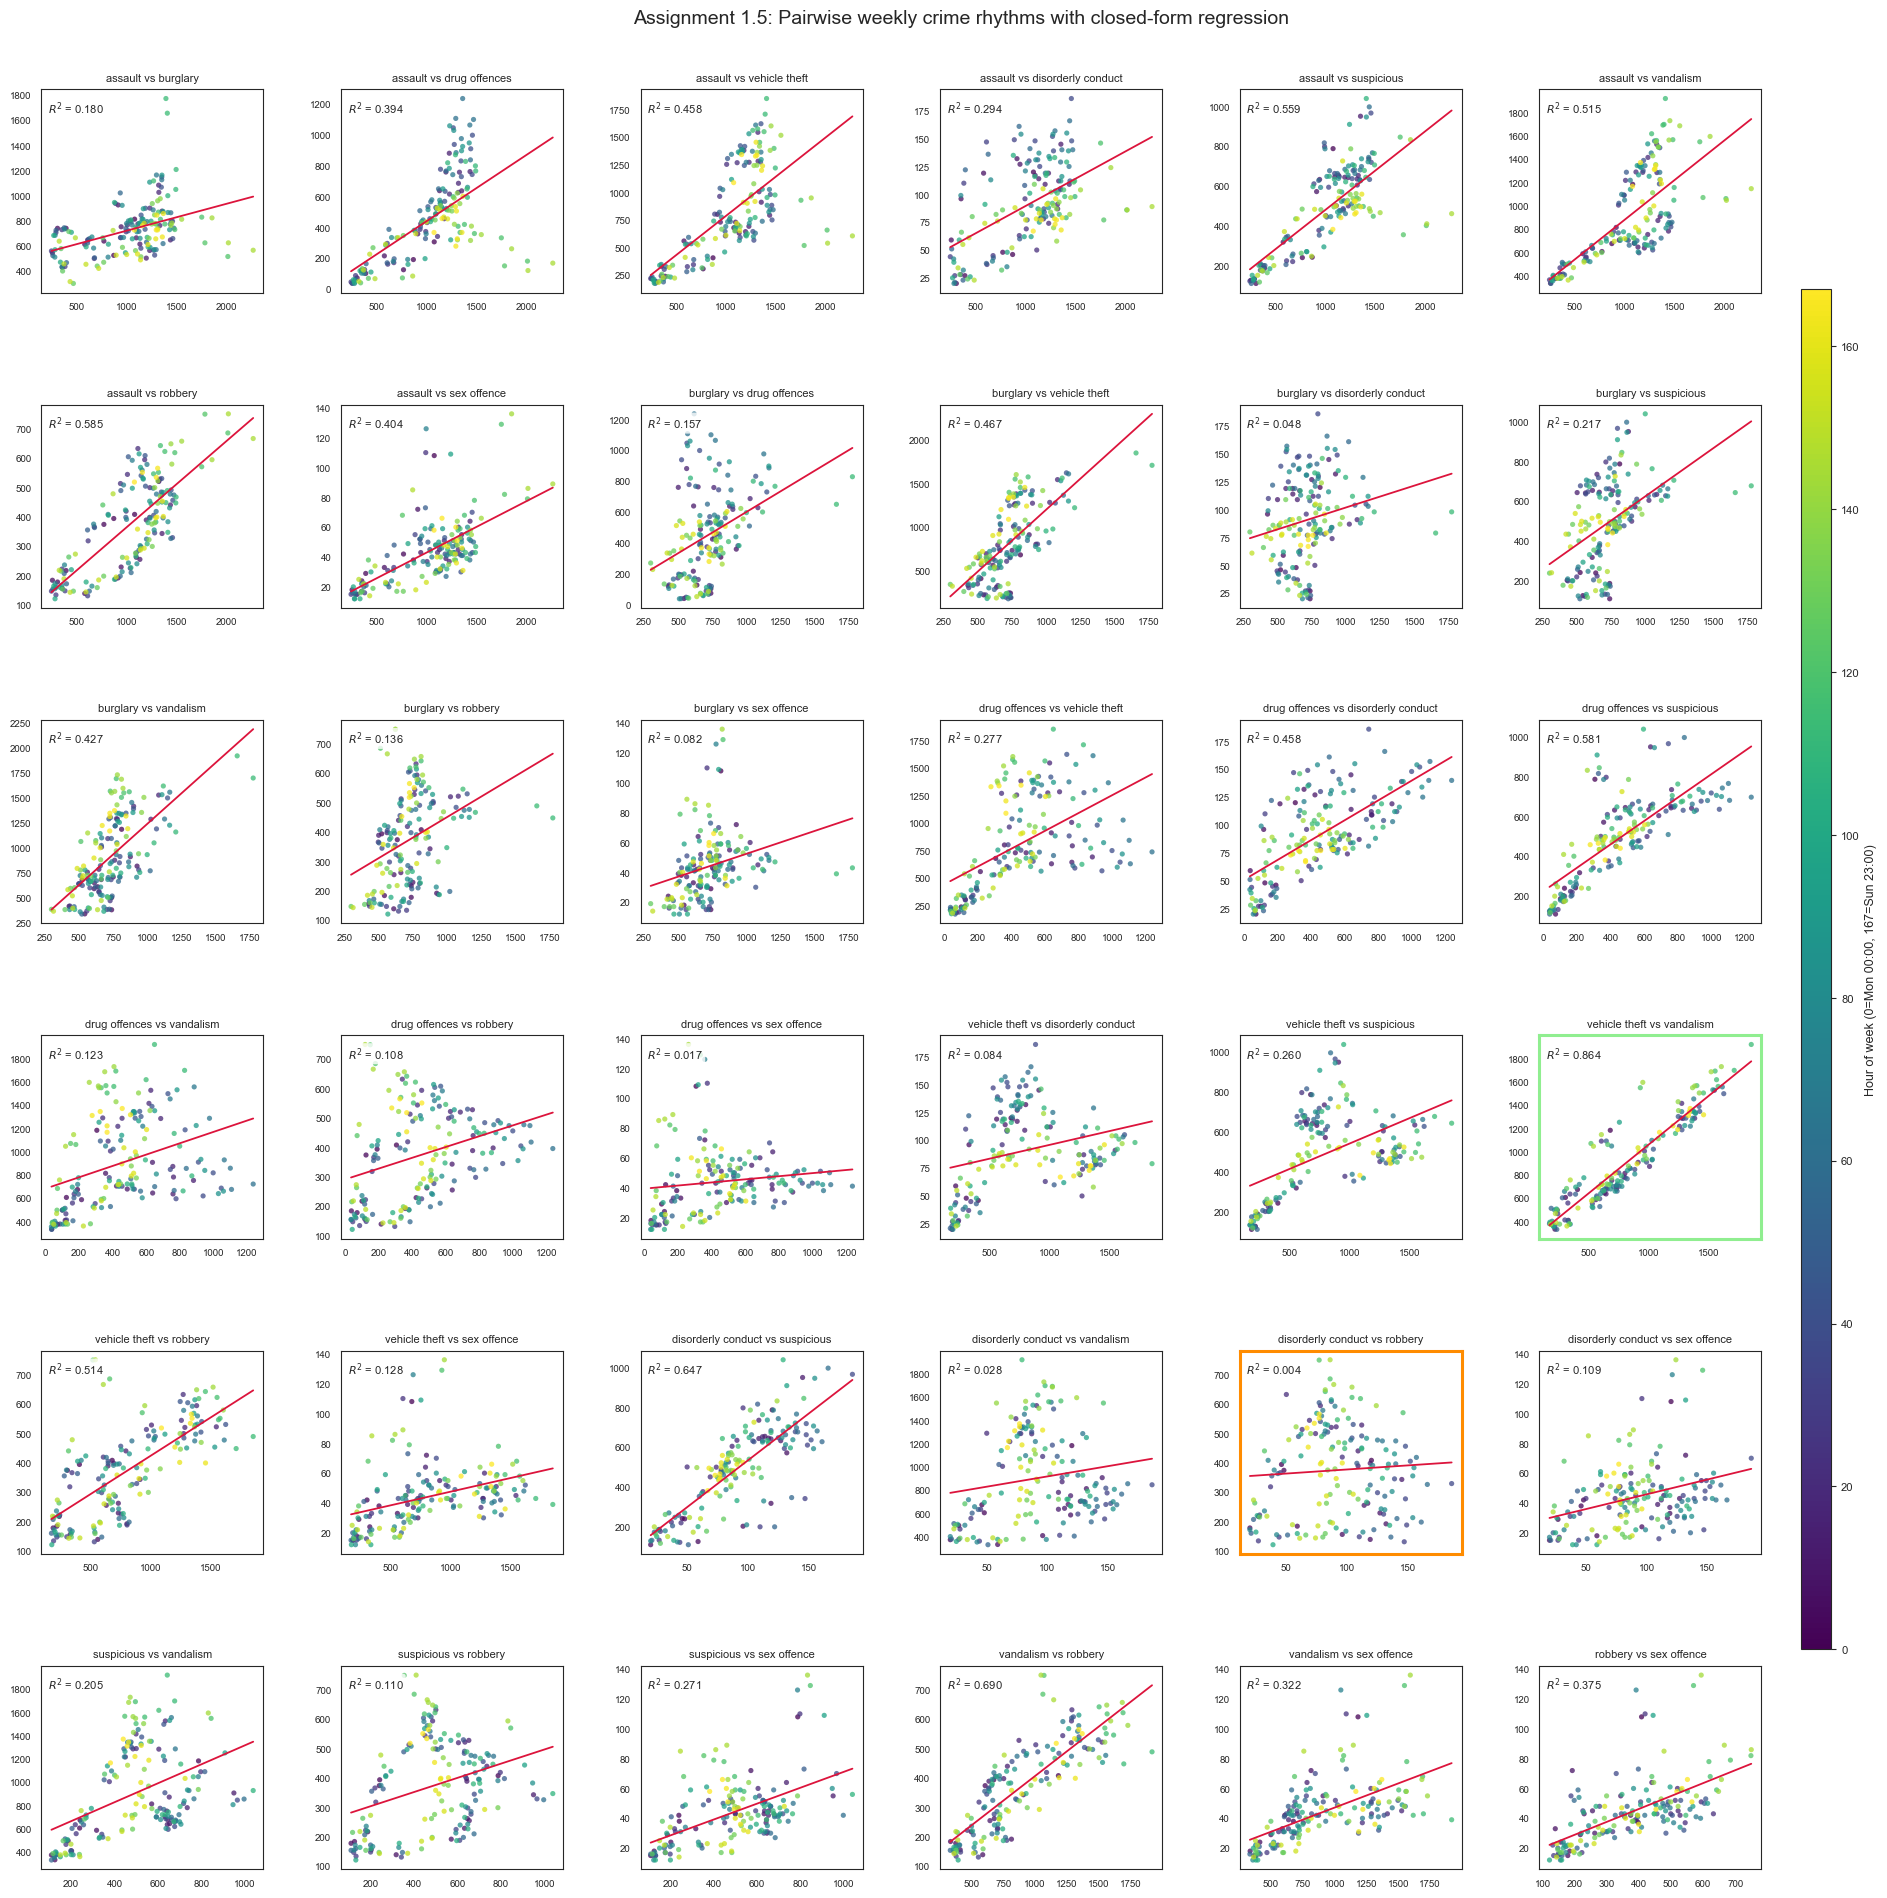

Most correlated pair by R^2: vehicle theft vs vandalism (R^2 = 0.864)
Least correlated pair by R^2: disorderly conduct vs robbery (R^2 = 0.004)


In [20]:
from itertools import combinations

selected_crimes = focus.copy()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Build 168-hour weekly count vectors for each crime
df_15 = focus_data[focus_data["Category"].isin(selected_crimes)].copy()
df_15["DayOfWeek"] = pd.Categorical(df_15["DayOfWeek"], categories=day_order, ordered=True)
df_15["hour"] = pd.to_datetime(df_15["Time"], format="%H:%M", errors="coerce").dt.hour
df_15 = df_15.dropna(subset=["hour", "DayOfWeek"])
df_15["hour"] = df_15["hour"].astype(int)

full_index = pd.MultiIndex.from_product(
    [selected_crimes, day_order, range(24)],
    names=["Category", "DayOfWeek", "hour"]
)

weekly_counts = (
    df_15.groupby(["Category", "DayOfWeek", "hour"]).size()
    .reindex(full_index, fill_value=0)
    .rename("count")
    .reset_index()
)
weekly_counts["hour_of_week"] = weekly_counts["DayOfWeek"].map({d: i for i, d in enumerate(day_order)}) * 24 + weekly_counts["hour"]

weekly_vectors = {
    crime: weekly_counts[weekly_counts["Category"] == crime].sort_values("hour_of_week")["count"].to_numpy()
    for crime in selected_crimes
}

def linear_fit_closed_form(x, y):
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    a_num = (x * y).sum() - N * x_mean * y_mean
    a_den = (x ** 2).sum() - N * (x_mean ** 2)
    a = a_num / a_den if a_den != 0 else 0.0
    b = y_mean - a * x_mean
    return a, b

def r2_manual(x, y, a, b):
    y_hat = a * x + b
    ss_res = ((y - y_hat) ** 2).sum()
    ss_tot = ((y - y.mean()) ** 2).sum()
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
    return 1 - ss_res / ss_tot

# Compute pairwise fit parameters and R^2
pairs = list(combinations(selected_crimes, 2))
pair_results = []

for cx, cy in pairs:
    x = weekly_vectors[cx]
    y = weekly_vectors[cy]
    a, b = linear_fit_closed_form(x, y)
    r2 = r2_manual(x, y, a, b)
    pair_results.append({"crime_x": cx, "crime_y": cy, "a": a, "b": b, "R2": r2})

pair_df = pd.DataFrame(pair_results).sort_values("R2", ascending=False).reset_index(drop=True)
best_pair = tuple(pair_df.loc[0, ["crime_x", "crime_y"]])
worst_pair = tuple(pair_df.loc[pair_df.index[-1], ["crime_x", "crime_y"]])

# Plot all 36 pairwise comparisons in a 6x6 matrix 
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
hour_gradient = np.arange(168)

for ax, (cx, cy) in zip(axes.flat, pairs):
    row = pair_df[(pair_df["crime_x"] == cx) & (pair_df["crime_y"] == cy)].iloc[0]
    x = weekly_vectors[cx]
    y = weekly_vectors[cy]

    ax.scatter(x, y, c=hour_gradient, cmap="viridis", s=14, alpha=0.75, edgecolors="none")
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, row["a"] * x_line + row["b"], color="crimson", linewidth=1.3)
    ax.set_title(f"{cx} vs {cy}", fontsize=8)
    ax.tick_params(labelsize=7)
    ax.text(
        0.03, 0.95, f"$R^2$ = {row['R2']:.3f}",
        transform=ax.transAxes, ha="left", va="top", fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, edgecolor="none")
    )

    if (cx, cy) == best_pair:
        for spine in ax.spines.values():
            spine.set_edgecolor("lightgreen")
            spine.set_linewidth(2.2)
    elif (cx, cy) == worst_pair:
        for spine in ax.spines.values():
            spine.set_edgecolor("darkorange")
            spine.set_linewidth(2.2)


for ax in axes.flat[len(pairs):]:
    ax.axis("off")

fig.suptitle("Assignment 1.5: Pairwise weekly crime rhythms with closed-form regression", fontsize=14, y=0.98)
fig.subplots_adjust(left=0.04, right=0.90, bottom=0.05, top=0.94, wspace=0.35, hspace=0.55)

# Colorbar in dedicated axis so it never covers subplot panels
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(0, 167))
sm.set_array([])
cax = fig.add_axes([0.92, 0.16, 0.015, 0.68])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Hour of week (0=Mon 00:00, 167=Sun 23:00)", fontsize=9)
cbar.ax.tick_params(labelsize=8)

plt.show()

print(f"Most correlated pair by R^2: {best_pair[0]} vs {best_pair[1]} (R^2 = {pair_df.loc[0, 'R2']:.3f})")
print(f"Least correlated pair by R^2: {worst_pair[0]} vs {worst_pair[1]} (R^2 = {pair_df.loc[pair_df.index[-1], 'R2']:.3f})")


**Figure 1.5:** Pairwise scatterplot matrix for all 36 crime-pair combinations (9 focus crimes). Each point is one hour of the week (168 points per panel), colors encode temporal progression through the week, red lines are closed-form linear fits, and panel labels report $R^2$. Green border marks the most correlated pair; orange border marks the least correlated pair.


### Results and interpretation

The **most** correlated pair is vehicle theft vs vandalism with $R^2 \approx 0.848$. This suggests a strong shared weekly rhythm, which makes sense because both are property related crimes often tied to similar conditions (traffic patterns, parking behavior, and nighttime/weekend activity).

The **least** correlated pair is disorderly conduct vs robbery with $R^2 \approx 0.004$, indicating almost no linear alignment in their weekly patterns. That also makes sense. Disorderly conduct is often linked to local street-level disturbances and enforcement context, while robbery can be driven by different situational opportunities and victim/offender dynamics.

Overall, the regression matrix shows that some crime categories appear to move together across the week, while others are effectively out of sync. This supports the idea that different crime types are generated by different social factors and local conditions, even within the same city and time period.


In [21]:

pair_df[["crime_x", "crime_y", "R2"]].head(10)


,crime_x,crime_y,R2
0,vehicle theft,vandalism,0.864090
1,vandalism,robbery,0.690431
2,disorderly conduct,suspicious,0.646609
3,assault,robbery,0.584564
4,drug offences,suspicious,0.581462
5,assault,suspicious,0.558860
6,assault,vandalism,0.515313
7,vehicle theft,robbery,0.513977
8,burglary,vehicle theft,0.467386
9,drug offences,disorderly conduct,0.457956


## Contributions

Name/Student nr.| Contributions |
| -------- | -------- |
|   |     |
| Sara Sterlie / S204674 | 1.1 and 1.4 |
| Thorsteinn Hoskuldsson / S253555 | 1.5 |

References: 

[1] City and County of San Francisco (2025) Police Department Incident Reports: Historical 2003 to May 2018: DataSF, Seal of the City and County of San Francisco. Available at: https://data.sfgov.org/d/tmnf-yvry (Accessed: 27 February 2026). 

[2] City and County of San Francisco (2025) Police Department Incident Reports: Historical 2003 to May 2018: DataSF, Seal of the City and County of San Francisco. Available at: https://data.sfgov.org/d/tmnf-yvry (Accessed: 27 February 2026). 

[3] Tracking San Francisco’s drug overdose epidemic. Available at: https://www.sfchronicle.com/projects/san-francisco-drug-overdose-deaths/ (Accessed: 27 February 2026). 

[4] Pena, L. (2026) SF mayor signs legislation for officers to arrest drug users, send them to reset center, ABC7 San Francisco. Available at: https://abc7news.com/post/san-francisco-mayor-signs-legislation-police-sheriff-deputies-arrest-drug-users-send-reset-center/18613975/ (Accessed: 25 February 2026). 
